# NOAA Multi-Radar / Multi-Sensor System (MRMS) 3D Mosaic 

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate a three-dimensional mosaic for Chicago. 

In [1]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import io
import gzip
import geopandas as gpd
import pandas as pd
import numpy as np

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import GoogleTiles, OSM
from matplotlib.transforms import offset_copy
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from metpy.plots import USCOUNTIES

import cmweather

## Default Configuration

In [18]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20250304"
##TIME = "130039" + "*"
TIME = ""
HOUR = "13"

In [3]:
# Site attributes
global_NEIU = {'conventions': "CF 1.10",
               'site_ID' : "NEIU",
               'CAMS_tag' : "CMS-WXT-002",
               'datastream' : "CMS_wxt536_NEIU_a1",
               'datalevel' : "a1",
               "wxt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
               "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
               'WSN' : 'W08D',
               'latitude' : 41.9804526,
               'longitude' : -87.7196038}
    
global_NU = {'conventions': "CF 1.10",
             'WSN':'W099',
             'site_ID' : "NU",
             'CAMS_tag' : "CMS-WXT-005",
             'datastream' : "CMS_wxt536_NU_a1",
             'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
             "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
             'datalevel' : "a1",
             'latitude' : 42.051469749,
             'longitude' : -87.677667183}
    
global_CSU = {'conventions': "CF 1.10",
              'WSN':'W08E',
              'site_ID' : "CSU",
              'CAMS_tag' : "CMS-WXT-003",
              'datastream' : "CMS_wxt536_CSU_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.71991216,
              'longitude' : -87.612834722}
    
global_UIC = {'conventions': "CF 1.10",
              'WSN':'W096',
              'site_ID' : "UIC",
              'CAMS_tag' : "CMS-WXT-006",
              'datastream' : "CMS_wxt536_UIC_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.86943346,
              'longitude' : -87.645337665}
    
global_ATMOS = {'conventions': "CF 1.10",
                'WSN':'W0A4',
                'site_ID' : "ATMOS",
                'CAMS_tag' : "CMS-WXT-001",
                'datastream' : "CMS_wxt536_ATMOS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.701556533,
                'longitude' : -87.99507543}
    
global_CCICS = {'conventions': "CF 1.10",
                'WSN':'W08B',
                'site_ID' : "CCICS",
                'CAMS_tag' : "CMS-WXT-099",
                'datastream' : "CMS_wxt536_CCICS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.822953674,
                'longitude' : -87.609452418}

global_BIG   = {'conventions': "CF 1.10",
                    'WSN':'W0A0',
                    'site_ID' : "BIG",
                    'CAMS_tag' : "CMS-WXT-014",
                    'datastream' : "CMS_wxt536_BIG_a1",
                    'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                    "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                    'datalevel' : "a1",
                    'latitude' : 41.777009821,
                    'longitude' : -87.609746965}
    
global_HUM  =  {'conventions': "CF 1.10",
                'WSN':'W0A1',
                'site_ID' : "HUM",
                'CAMS_tag' : "CMS-WXT-010",
                'datastream' : "CMS_wxt536_HUM_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.905513206,
                'longitude' : -87.703525713}
    
global_DOWN = {'conventions': "CF 1.10",
               'WSN':'W09D',
               'site_ID' : "DOWN",
               'CAMS_tag' : "CMS-WXT-008",
               'datastream' : "CMS_wxt536_DOWN_a1",
               'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
               "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
               'datalevel' : "a1",
               'latitude' : 41.795306577,
               'longitude' : -88.006144107}
    
global_SHEDD = {'conventions': "CF 1.10",
                'WSN':'W09E',
                'site_ID' : "SHEDD",
                'CAMS_tag' : "CMS-WXT-007",
                'datastream' : "CMS_wxt536_SHEDD_a1",
                'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.867953617,
                'longitude' : -87.613603892}
    
#put these in a dictionary for accessing
global_sites = {'NU' : global_NU, 
                'CSU': global_CSU,
                'NEIU': global_NEIU,
                'UIC': global_UIC,
                'ATMOS': global_ATMOS,
                'CCICS': global_CCICS,
                'BIG': global_BIG,
                'HUM': global_HUM,
                "DOWN": global_DOWN,
                "SHEDD": global_SHEDD}

In [4]:
chi_box = [271.9, 272.5, 41.6, 42.15]
lake_box = [271.5, 273.0, 41.5, 42.5]

## Define the S3 Bucket Directories

Note that each elevation level contains it's own file

In [19]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

In [ ]:
s3_bucket = [f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_01.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_01.25/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_01.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_01.75/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_02.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_02.25/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_02.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_02.75/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_03.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_03.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_04.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_04.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_05.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_05.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_06.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_06.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_07.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_07.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_08.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_08.50/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_09.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_10.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_11.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_12.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_13.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_14.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_15.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_16.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_17.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_18.00/{DATE}/*{DATE}-{HOUR}*",
             f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_19.00/{DATE}/*{DATE}-{HOUR}*"]

In [24]:
sorted(fs.glob(f"s3://noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/{DATE}/*{DATE}-{HOUR}*"))

['noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130039.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130239.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130438.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130641.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130838.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131039.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131238.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131442.grib2.gz',
 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_M

In [ ]:
# Download, Uncompress, Read, Convert the MRMS Data, store in list for concatenation
ds_list = []
for scan in s3_bucket:
    file_path = sorted(fs.glob(scan))
    print(file_path)
    elev_list = []
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name)
                # To concatenate, need to add in elevation level
                ds = ds.assign_coords({"elevation" : float(file_path[0].split('/')[-1].split("_")[-2])})
                ds["elevation"].attrs["units"] = "Kilometers Above Mean Sea Level"
                # Variables are `unknown` in these files, rename and assign units
                ds = ds.rename({"unknown" : "DBZ"})
                ds["DBZ"].attrs["units"] = "dBZ"
                ds["DBZ"].attrs["long_name"] = "Reflectivity"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(chi_box[3], chi_box[2]), longitude=slice(chi_box[0], chi_box[1])).where(ds.DBZ > -20)
                # Transition to degrees west
                ds['longitude'] = ds['longitude'].data - 360
                ds['longitude'].attrs['units'] = "degrees_east"
                # save for concatenation
                elev_list.append(ds)
    # Concatenation per elevation
    ds_list.append(xr.concat(elev_list, dim="elevation"))
    # free up space
    del elev_list

['noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130039.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130239.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130438.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130641.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-130838.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131039.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131238.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedReflectivityQC_00.50_20250304-131442.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.50/20250304/MRMS_MergedRef

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(41) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(41) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-ze

['noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-000040.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-000240.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-000437.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-000637.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-000839.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-001038.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-001236.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedReflectivityQC_00.75_20250304-001439.grib2.gz', 'noaa-mrms-pds/CONUS/MergedReflectivityQC_00.75/20250304/MRMS_MergedRef

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(37) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(37) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(37) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(37) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-ze

KeyboardInterrupt: 

In [9]:
# concatenate the scans
ds_merged = xr.concat(ds_list, dim="elevation")

In [10]:
ds_merged

<xarray.Dataset> Size: 438kB
Dimensions:         (elevation: 33, latitude: 55, longitude: 60)
Coordinates:
  * latitude        (latitude) float64 440B 42.15 42.14 42.13 ... 41.62 41.61
  * longitude       (longitude) float64 480B -88.1 -88.09 ... -87.52 -87.51
    time            (elevation) datetime64[ns] 264B 2025-03-04 ... 2025-03-04...
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  (elevation) float64 264B 500.0 750.0 ... 1.8e+04 1.9e+04
    valid_time      (elevation) datetime64[ns] 264B 2025-03-04 ... 2025-03-04...
  * elevation       (elevation) float64 264B 0.5 0.75 1.0 ... 17.0 18.0 19.0
Data variables:
    DBZ             (elevation, latitude, longitude) float32 436kB nan ... nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-06T16:35 GRIB to CDM+CF via cfgrib-0.9.1...

## Initial PPI Display

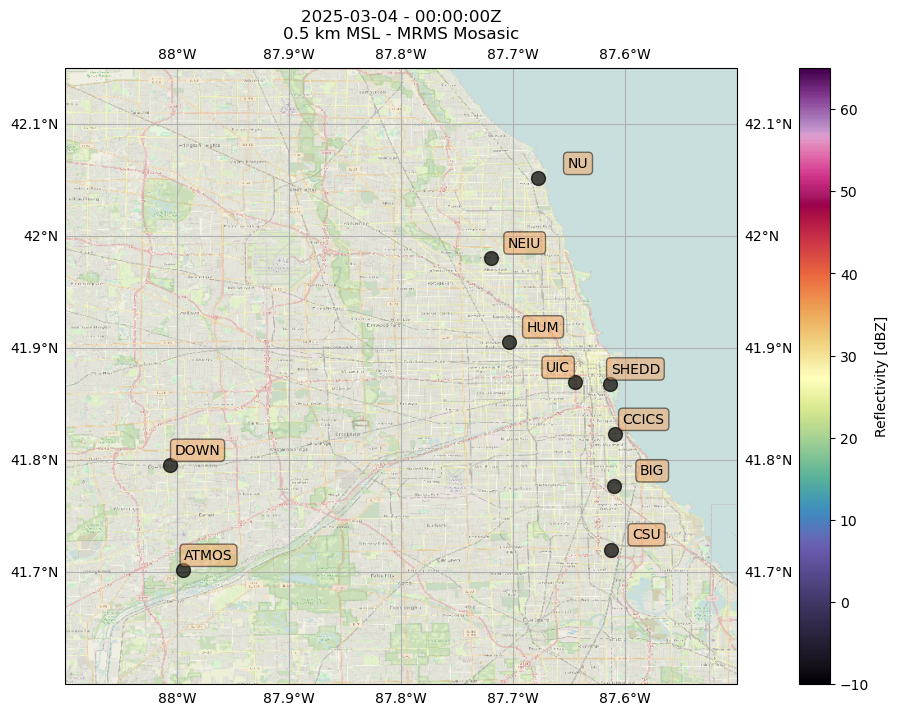

In [14]:
from cartopy.io.img_tiles import GoogleTiles, OSM
from matplotlib.transforms import offset_copy
import numpy as np

# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

fig = plt.figure(figsize=(16, 8))
tiler = OSM()
mercator = tiler.crs
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

## subset the data
ds_merged.isel(elevation=0).DBZ.plot(transform=ccrs.PlateCarree(),
                                     vmin=-10, 
                                     vmax=65, 
                                     ax=ax,
                                     cmap="ChaseSpectral")

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 12, zorder=1, alpha=0.55)
ax.gridlines(draw_labels=True)

# Set plot bounds
ax.set_extent(chi_box)

# Display the location of the CROCUS nodes
for key in global_sites:
    # Add a marker for the CROCUS sites.
    ax.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # SHEDD and UIC are to close to each other. If UIC, plot to the left.
    if key == "UIC":
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude']-0.07, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    else:
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    
# update the title of the display
ax.set_title(np.datetime_as_string(ds_merged['valid_time'].data[0], unit='s').replace("T", " - ") + 
             "Z\n" + str(ds_merged['elevation'].data[0]) + " km MSL - MRMS Mosasic")

##plt.savefig("/Users/jrobrien/dev/crocus/images/cref_example.png")
plt.show()

## Latitudinal Display

In [ ]:
ds_merged.sel(longitude=slice(chi_box[0]-360, chi_box[1]-360)).sel(latitude=global_sites['NEIU']["latitude"], method="nearest").DBZ.plot(y="elevation", 
                                                                                                                                 vmin=-10, 
                                                                                                                                 vmax=60,
                                                                                                                                 cmap="ChaseSpectral")

In [ ]:
ds_merged.sel(longitude=slice(chi_box[0]-360, chi_box[1]-360)).sel(latitude=global_sites['NEIU']['latitude'], method="nearest").DBZ.plot(y="elevation", 
                                                                                                                                 vmin=-10, 
                                                                                                                                 vmax=60,
                                                                                                                                 cmap="ChaseSpectral")

## Multi-Panel Reflectivity Display (Grid-spec)

In [ ]:
#---------------------------------------------------
# Define the GridSpec for Detailed Subplot Placement
#---------------------------------------------------
figB = plt.figure(figsize=(14, 8))

gs0 = gridspec.GridSpec(1, 2, figure=figB)
gs00 = gs0[1].subgridspec(2, 1, hspace=.32)

# update the extent of the subplot
gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)

# -----------------------------
# Display the Gridded Elevation
# -----------------------------
ax = figB.add_subplot(gs0[0], projection=ccrs.PlateCarree())

## subset the data
ds_merged.isel(elevation=0).DBZ.plot(transform=ccrs.PlateCarree(),
                                     vmin=-15, 
                                     vmax=65, 
                                     ax=ax,
                                     cmap="ChaseSpectral",
                                     cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 12, zorder=1, alpha=0.55)
ax.gridlines(draw_labels=True)

# Set plot bounds
ax.set_extent(chi_box)

# add in crosshairs to indicate the lat/lon slices
ax.axhline(y=global_sites["NEIU"]["latitude"], color="black", linestyle="--")
ax.axvline(x=global_sites["NEIU"]["longitude"], color="red", linestyle="--")

# Display the location of the CROCUS nodes
for key in global_sites:
    # Add a marker for the CROCUS sites.
    ax.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # SHEDD and UIC are to close to each other. If UIC, plot to the left.
    if key == "UIC":
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude']-0.07, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    elif key == "BIG" or key == "NU" or key == "CSU":
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude']-0.05, 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='left', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    else:
        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
    
# update the title of the display
ax.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
             "Z\n" + str(ds_merged['elevation'].data[0]) + " km MSL - MRMS Mosasic")

# ---------------------------
# Display the Latitudal Slice
# ---------------------------
ax2 = figB.add_subplot(gs00[0])
ds_merged.sel(latitude=global_sites['NEIU']['latitude'], method="nearest").sel(longitude=slice(chi_box[0]-360, chi_box[1]-360)).DBZ.plot(y="elevation", 
                                                                                                                                 vmin=-10, 
                                                                                                                                 vmax=60,
                                                                                                                                 ax=ax2,
                                                                                                                                 cmap="ChaseSpectral")
ax2.set_title("CROCUS Node - NEIU; " + "Latitude = " + str(global_sites["NEIU"]["latitude"]) + r"$\degree$")
ax2.set_ylabel("Height \n [km above MSL]")
ax2.set_xlabel(r"Longitude $\degree$")

# ----------------------------
# Display the Longitudal Slice
# ----------------------------
ax3 = figB.add_subplot(gs00[1])
ds_merged.sel(longitude=global_sites['NEIU']['longitude'], method="nearest").sel(latitude=slice(chi_box[3], chi_box[2])).DBZ.plot(y="elevation", 
                                                                                                                                  vmin=-10, 
                                                                                                                                  vmax=60,
                                                                                                                                  ax=ax3,
                                                                                                                                  cmap="ChaseSpectral")
ax3.set_title("CROCUS Node - NEIU; Longitude = " + str(global_sites["NEIU"]["longitude"]) + r"$\degree$", color="red")
ax3.set_ylabel("Height \n [km above MSL]")
ax3.set_xlabel(r"Latitude $\degree$")
#plt.show()

plt.savefig("/Users/jrobrien/dev/crocus/images/mrms-3dref-example.png")


## Wrap up this work into a function, create gif for entire day

In [ ]:
def mrms_ref_mosaic(ds_merged, global_sites, site="NEIU"):
    """
    Create a display to visualize MRMS 3D Reflectivity across
     the Chicago-CROCUS domain, marking locations of the nodes,
     and taking latitudial/longitudal slices. 

    Input
    -----
    ds_merged - xarray dataset
        MRMS 3-D Reflectivity, previously uncompressed and merged

    global_sites : dict
        Information that are specific to the CROCUS sites.
    
    slice : str
        Identifer of the node for lat/lon slices

    Returns
    -------
    axarr : Matplotlib.pyplot Figure 
        Figure instance containing the desired quicklook; to be saved outside 
        of function
    """
    # Defaults
    chi_box = [271.9, 272.5, 41.6, 42.15]
    lake_box = [271.5, 273.0, 41.5, 42.5]

    #---------------------------------------------------
    # Define the GridSpec for Detailed Subplot Placement
    #---------------------------------------------------
    fig = plt.figure(figsize=(14, 8))
    tiler = OSM()
    mercator = tiler.crs

    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(2, 1, hspace=.32)

    # update the extent of the subplot
    gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)

    # -----------------------------
    # Display the Gridded Elevation
    # -----------------------------
    ax = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())

    ## subset the data
    ds_merged.isel(elevation=0).DBZ.plot(transform=ccrs.PlateCarree(),
                                         vmin=-15, 
                                         vmax=65, 
                                         ax=ax,
                                         cmap="ChaseSpectral",
                                         cbar_kwargs={"location" : "bottom"})

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_image(tiler, 12, zorder=1, alpha=0.55)
    ax.gridlines(draw_labels=True)

    # Set plot bounds
    ax.set_extent(chi_box)

    # add in crosshairs to indicate the lat/lon slices
    ax.axhline(y=global_sites[site]["latitude"], color="black", linestyle="--")
    ax.axvline(x=global_sites[site]["longitude"], color="red", linestyle="--")

    # Display the location of the CROCUS nodes
    for key in global_sites:
        # Add a marker for the CROCUS sites.
        ax.plot(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                marker='o', 
                color='black', 
                markersize=10, 
                alpha=0.7, 
                transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # SHEDD and UIC are to close to each other. If UIC, plot to the left.
        if key == "UIC":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.07, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        elif key == "BIG" or key == "NU" or key == "CSU":
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude']-0.05, 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax.text(global_sites[key]['longitude'], 
                    global_sites[key]['latitude'], 
                    global_sites[key]['site_ID'], 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
    
    # update the title of the display
    ax.set_title(np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", " - ") + 
                 "Z\n" + str(ds_merged['elevation'].data[0]) + " km MSL - MRMS Mosasic")

    # ---------------------------
    # Display the Latitudal Slice
    # ---------------------------
    ax2 = fig.add_subplot(gs00[0])
    joe = global_sites[site]['latitude']
    print(chi_box[1])
    ds_merged.sel(latitude=global_sites[site]['latitude'], method="nearest").sel(longitude=slice(chi_box[0]-360, chi_box[1]-360)).DBZ.plot(y="elevation", 
                                                                                                                                             vmin=-10, 
                                                                                                                                             vmax=60,
                                                                                                                                             ax=ax2,
                                                                                                                                             cmap="ChaseSpectral")
    ax2.set_title("CROCUS Node - " + global_sites[site]["site_ID"] + "; + Latitude = " + str(global_sites[site]["latitude"]) + r"$\degree$")
    ax2.set_ylabel("Height \n [km above MSL]")
    ax2.set_xlabel(r"Longitude $\degree$")

    # ----------------------------
    # Display the Longitudal Slice
    # ----------------------------
    ax3 = fig.add_subplot(gs00[1])
    ds_merged.sel(longitude=global_sites[site]['longitude'], method="nearest").sel(latitude=slice(chi_box[3], chi_box[2])).DBZ.plot(y="elevation", 
                                                                                                                                      vmin=-10, 
                                                                                                                                      vmax=60,
                                                                                                                                      ax=ax3,
                                                                                                                                      cmap="ChaseSpectral")
    ax3.set_title("CROCUS Node - " + global_sites[site]["site_ID"] + "; Longitude = " + str(global_sites[site]["longitude"]) + r"$\degree$", color="red")
    ax3.set_ylabel("Height \n [km above MSL]")
    ax3.set_xlabel(r"Latitude $\degree$")

    # free up memory
    ##del mrms, sdata, tiler

    return fig

In [ ]:
out_fig = mrms_ref_mosaic(ds_merged, global_sites, site="CSU")

In [ ]:
out_fig.savefig('/Users/jrobrien/dev/crocus/images/mrms-test.png')

In [ ]:
# define a temporary directory to hold static images
templocation = tempfile.mkdtemp()

for nfile in file_path[200:350]:
    with fs.open(nfile, 'rb') as gzip_file:
        with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
            f.write(gzip.decompress(gzip_file.read()))
            image = mrms_cref(f.name, global_sites)
            plt.savefig(templocation + 
                        '/' + 
                        'mrms-radar-cref-' + 
                        nfile.split('_')[-1].split('.')[0] +
                        '.png')

In [ ]:
import glob
import imageio
import os

def create_gif():
    # Define files created and define movie path
    map_images = sorted(glob.glob(templocation + f"/mrms-radar-cref*"))
    gif_title = f"mrms-radar-3dref-" + DATE + ".gif"

    # Check to see if the file exists - if it does, delete it
    if os.path.exists(gif_title):
        os.remove(gif_title)

    # Loop through and create the gif
    with imageio.get_writer(gif_title, mode='I', duration=0.2) as writer:
        for filename in map_images:
            print(filename)
            image = imageio.imread(filename)
            writer.append_data(image)

![SegmentLocal](../../images/mrms-radar-cref-20241031.gif "segment")